# Import Data

In [8]:
import osmnx as ox
import pandas as pd
import geopandas as gpd


# 1. Load your cleaned deliveries dataset (GeoPackage or CSV with geometry)
deliveries = gpd.read_file(
    "../data/deliveries_clustered_haversine.gpkg",
    engine="pyogrio",
    use_arrow=True
    )

# 2. Load the OSMnx city boundary
hyd_admin = ox.geocode_to_gdf("Hyderabad, Telangana, India")

# 3. Load road network
roads = gpd.read_file(
    "../data/hyd_roads.gpkg",
    engine="pyogrio",
    use_arrow=True
    )

# 4. Load hub location
data_path = '../data/ApexHub_Deliveries.xlsx'
df_dc = pd.read_excel(data_path, sheet_name='Distribution Center Location')
hub_lat, hub_lon = map(float, df_dc.loc[0, 'Hub Coordinates'].split(','))
print(f"Hub coordinates: {hub_lat}, {hub_lon}")

# 5. Project everything to EPSG:3857 for clustering (meters)
deliveries = deliveries.to_crs(epsg=3857)
hyd_admin = hyd_admin.to_crs(epsg=3857)
roads = roads.to_crs(epsg=3857)
hub = gpd.GeoDataFrame(
    {'geometry': [gpd.points_from_xy([hub_lon], [hub_lat])[0]]},
    crs='EPSG:4326'
).to_crs(epsg=3857)



Hub coordinates: 17.235389854, 78.41602866


# Compare OSMNx vs HDX Roads

In [39]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd

# Get Hyderabad boundary polygon (in WGS84 for OSMnx)
hyd_boundary_wgs = hyd_admin.to_crs(epsg=4326).geometry.iloc[0]

# Download 'drive' network within Hyderabad boundary
G_osmnx = ox.graph_from_polygon(hyd_boundary_wgs, network_type='drive_service')


In [40]:
# Convert graph to GeoDataFrames for plotting
nodes_osmnx, edges_osmnx = ox.graph_to_gdfs(G_osmnx)

# Project for plotting
edges_osmnx_web = edges_osmnx.to_crs(epsg=3857)
roads_web = roads.to_crs(epsg=3857)
hyd_admin_web = hyd_admin.to_crs(epsg=3857)


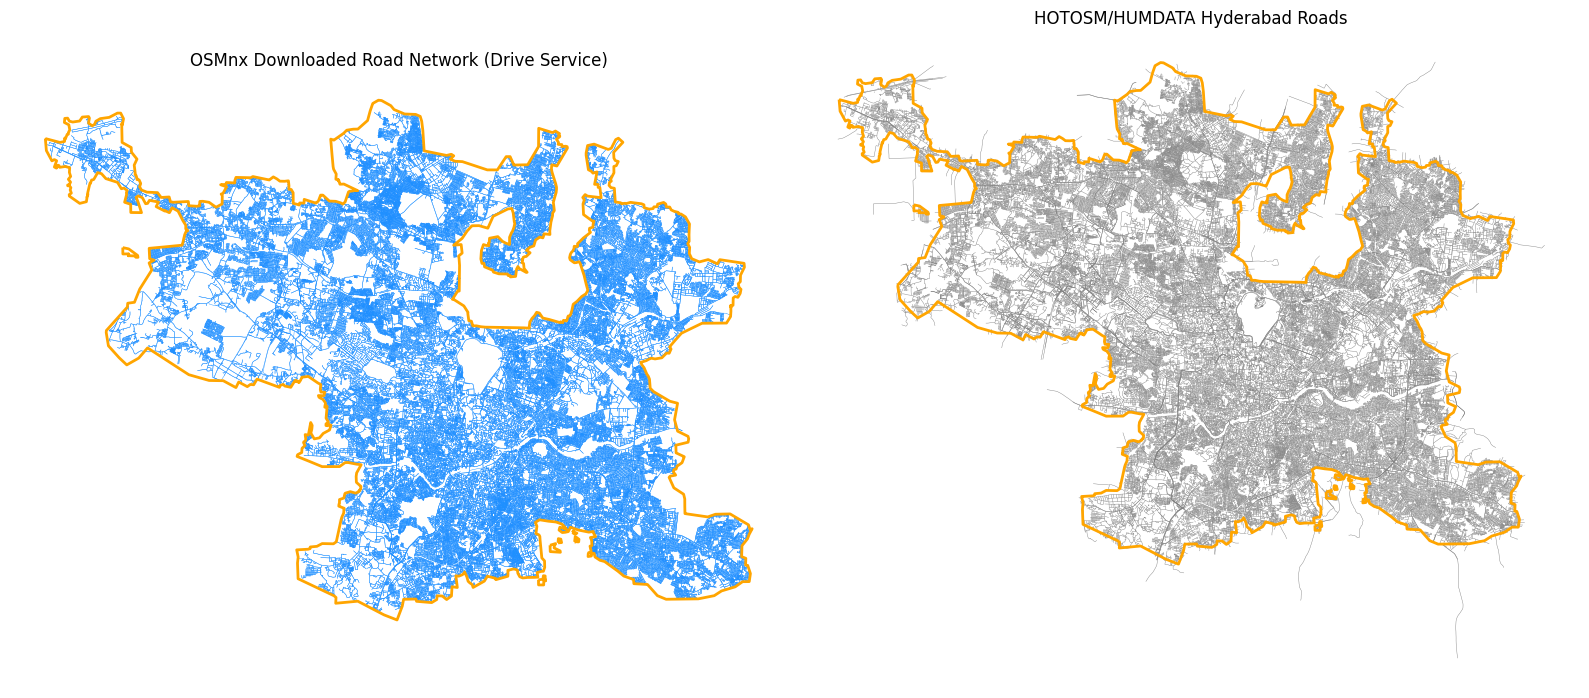

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# OSMnx graph
edges_osmnx_web.plot(ax=axes[0], linewidth=0.3, color='dodgerblue')
hyd_admin_web.boundary.plot(ax=axes[0], color='orange', linewidth=2)
axes[0].set_title("OSMnx Downloaded Road Network (Drive Service)")
axes[0].set_axis_off()

# Your HOTOSM/HUMDATA clipped roads
roads_web.plot(ax=axes[1], linewidth=0.3, color='gray')
hyd_admin_web.boundary.plot(ax=axes[1], color='orange', linewidth=2)
axes[1].set_title("HOTOSM/HUMDATA Hyderabad Roads")
axes[1].set_axis_off()

plt.tight_layout()

output_path = "../outputs/osmnx_vs_hotosm_hyd_roads.png"
fig.savefig(
    output_path, 
    dpi=500, 
    bbox_inches='tight', 
    transparent=True
)

plt.show()


# Sub-graphs

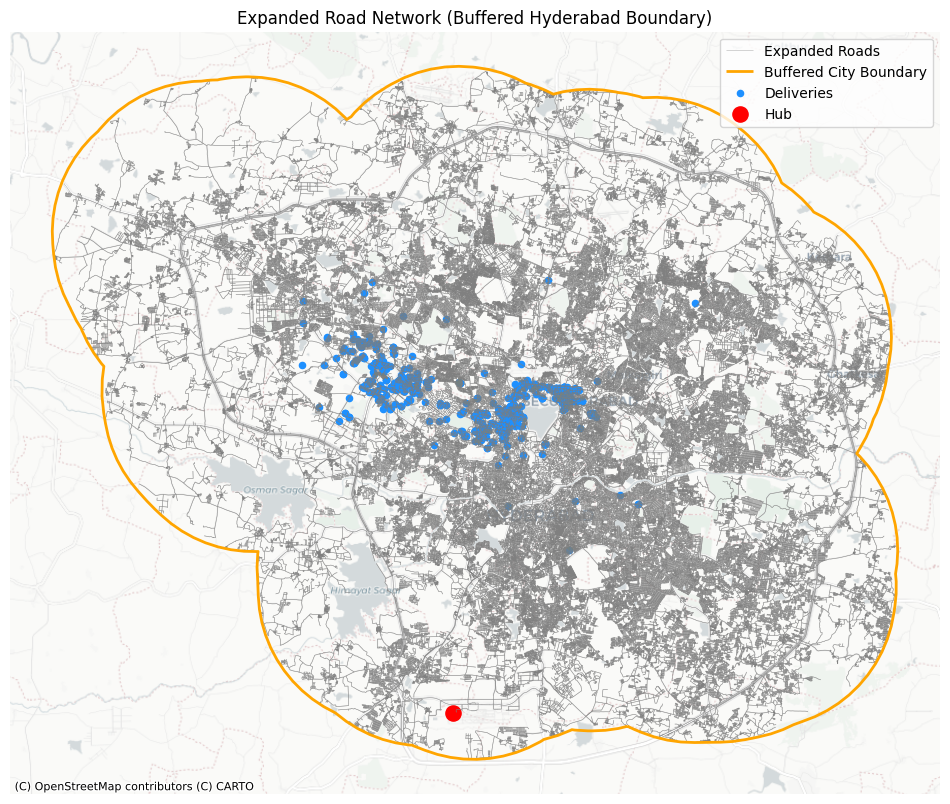

In [42]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Buffer in meters using EPSG:3857
hyd_admin_3857 = hyd_admin.to_crs(epsg=3857)
hyd_buffered_3857 = hyd_admin_3857.geometry.buffer(10_000)

# Create GeoDataFrame with EPSG:3857
hyd_buffered_gdf_3857 = gpd.GeoDataFrame(geometry=hyd_buffered_3857, crs="EPSG:3857")

# Project *just the geometry* to EPSG:4326 for OSMnx
hyd_buffered_wgs = hyd_buffered_gdf_3857.to_crs(epsg=4326)
hyd_polygon_buffered = hyd_buffered_wgs.geometry.iloc[0]

# Get the expanded road network
G_osmnx_expanded = ox.graph_from_polygon(hyd_polygon_buffered, network_type='drive')
nodes_exp, edges_exp = ox.graph_to_gdfs(G_osmnx_expanded)

# Make sure ALL layers for plotting are in 3857
edges_exp_3857 = edges_exp.to_crs(epsg=3857)
deliveries_3857 = deliveries.to_crs(epsg=3857)
hub_3857 = hub.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12,10))
edges_exp_3857.plot(ax=ax, linewidth=0.4, color='gray', alpha=0.6, label='Expanded Roads')
hyd_buffered_gdf_3857.boundary.plot(ax=ax, color='orange', linewidth=2, label='Buffered City Boundary')
deliveries_3857.plot(ax=ax, color='dodgerblue', markersize=20, label='Deliveries')
hub_3857.plot(ax=ax, color='red', markersize=120, label='Hub')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend()
plt.title("Expanded Road Network (Buffered Hyderabad Boundary)")
plt.show()


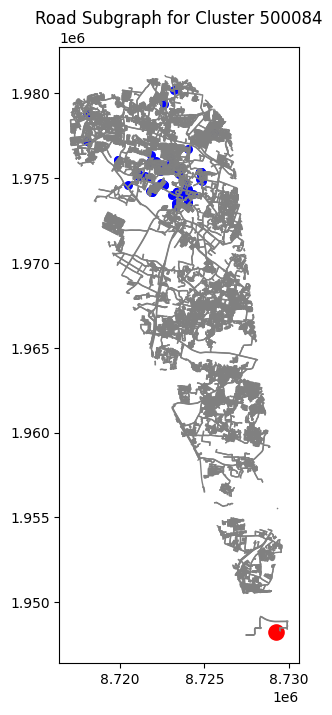

In [ ]:
# import matplotlib.pyplot as plt
# from shapely.geometry import MultiPoint

# # Example: for cluster 500084
# cluster_label = '500084'
# cluster_df = deliveries[deliveries['assigned_pincode'] == cluster_label]

# # Get all points: deliveries in cluster + hub
# all_points = list(cluster_df.geometry) + list(hub.geometry)
# # Create convex hull and buffer it a little (e.g., 1km)
# convex_hull = MultiPoint([pt for pt in all_points]).convex_hull.buffer(1000)  # buffer in meters

# # Project convex hull to WGS84 for OSMnx (graph is in lat/lon)
# convex_hull_wgs = gpd.GeoSeries([convex_hull], crs="EPSG:3857").to_crs(epsg=4326).iloc[0]

# # OSMnx graph nodes are in lat/lon (EPSG:4326)
# node_gdf = ox.graph_to_gdfs(G_osmnx_expanded, nodes=True, edges=False)
# nodes_in_hull = node_gdf[node_gdf.within(convex_hull_wgs)]
# G_sub = G_osmnx_expanded.subgraph(nodes_in_hull.index)

# sub_edges = ox.graph_to_gdfs(G_sub, nodes=False)
# sub_edges_3857 = sub_edges.to_crs(epsg=3857)
# ax = sub_edges_3857.plot(figsize=(8,8), linewidth=1, color='gray')
# cluster_df.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=30)
# hub_3857.plot(ax=ax, color='red', markersize=120)
# plt.title(f"Road Subgraph for Cluster {cluster_label}")
# plt.show()


In [ ]:
# import osmnx as ox

# # Get hub coordinates (make sure it's in WGS84 for OSMnx)
# hub_point = hub_gdf.geometry.iloc[0]
# if hub_gdf.crs.to_epsg() != 4326:
#     hub_point = hub_gdf.to_crs(4326).geometry.iloc[0]

# # Find nearest node to hub in G_sub (should work, if hub is inside G_sub)
# hub_node = ox.nearest_nodes(G_sub, hub_point.x, hub_point.y)

# # Similarly, get delivery node IDs (as before)
# delivery_nodes = [ox.nearest_nodes(G_sub, point.x, point.y) for point in cluster_df.geometry]

# # Now check connectivity
# for deliv_node in delivery_nodes:
#     if not nx.has_path(G_sub, hub_node, deliv_node):
#         print(f"No path from hub to delivery node {deliv_node}")

### ! seems there is disconnection from hub to deliveries within subgraphs, needs research 

No path from hub to delivery node 9838321547
No path from hub to delivery node 3602398400
No path from hub to delivery node 2225419826
No path from hub to delivery node 2766314839
No path from hub to delivery node 2763929147
No path from hub to delivery node 9838321547
No path from hub to delivery node 6150838829
No path from hub to delivery node 2225419826
No path from hub to delivery node 2225419574
No path from hub to delivery node 4206881267
No path from hub to delivery node 2763929147
No path from hub to delivery node 4191593452
No path from hub to delivery node 11502441386
No path from hub to delivery node 3109335283
No path from hub to delivery node 1655564105
No path from hub to delivery node 6150838829
No path from hub to delivery node 11502441386
No path from hub to delivery node 2763929147
No path from hub to delivery node 9838321547
No path from hub to delivery node 9838321547
No path from hub to delivery node 3602398400
No path from hub to delivery node 2763929147
No path 

# Benchmark Route Opt Algos

## Nearest Neighbor

In [73]:
import time
import networkx as nx
import numpy as np
import osmnx as ox

def nearest_neighbor_route(deliveries_gdf, hub_gdf, G, cluster_label=None, debug=False):
    """
    deliveries_gdf: GeoDataFrame for this cluster (EPSG:3857)
    hub_gdf: GeoDataFrame, single row, for the hub (EPSG:3857)
    G: OSMnx road network (should be in WGS84/EPSG:4326)
    cluster_label: for logging (assigned_pincode or similar)
    debug: for debugging key algo steps
    Returns: standardized results dict
    """
    # Project all points to WGS84 for OSMnx
    deliv_wgs = deliveries_gdf.to_crs(epsg=4326)
    hub_wgs = hub_gdf.to_crs(epsg=4326)
    
    # Get nearest network node for hub and deliveries
    hub_point = hub_wgs.geometry.iloc[0]
    hub_node = ox.nearest_nodes(G, hub_point.x, hub_point.y)
    deliv_nodes = ox.nearest_nodes(G, deliv_wgs.geometry.x, deliv_wgs.geometry.y)
    unvisited = set(deliv_nodes)
    
    # Start route at the hub
    current_node = hub_node
    route_nodes = [hub_node]
    total_length = 0.0
    t0 = time.time()
    if debug:
        print(f"Hub node: {hub_node}")
        print(f"Total Delivery nodes: {len(list(deliv_nodes))}")
    
    step = 0
    while unvisited:
        step += 1
        # Find nearest unvisited delivery node
        lengths = {n: np.inf for n in unvisited}
        for n in unvisited:
            try:
                lengths[n] = nx.shortest_path_length(G, current_node, n, weight='length')
            except nx.NetworkXNoPath:
                if debug:
                    print(f"[Step {step}] No path from {current_node} to {n}")
        next_node = min(lengths, key=lengths.get)
        if np.isinf(lengths[next_node]):
            if debug:
                print(f"[Step {step}] Could not find next node from {current_node}, disconnected, breaking loop.")
            break
        total_length += lengths[next_node]
        route_nodes.append(next_node)
        if debug:
            print(
                f"[Step {step}] Moved from {current_node} to {next_node}, distance: {lengths[next_node]:.1f} m, remaining: {len(unvisited)-1}"
                )
        current_node = next_node
        unvisited.remove(next_node)
    
    # Return to hub
    try:
        back_length = nx.shortest_path_length(G, current_node, hub_node, weight='length')
    except nx.NetworkXNoPath:
        back_length = 0
        if debug:
            print(f"Cannot return from {current_node} to hub {hub_node}")
    total_length += back_length
    route_nodes.append(hub_node)
    t1 = time.time()
    
    # For plotting: get (lat, lon)
    node_xy = []
    for n in route_nodes:
        data = G.nodes[n]
        node_xy.append((data['y'], data['x']))  # (lat, lon)
    
    if debug:
        print(f"Total route distance: {total_length/1000:.2f} km. Time: {t1-t0:.2f} s")

    return {
        'assigned_pincode': cluster_label,
        'algorithm': 'Nearest Neighbor',
        'ordered_node_ids': route_nodes,
        'ordered_latlon': node_xy,
        'total_distance_km': total_length / 1000,
        'run_time_seconds': t1 - t0,
        'notes': ''
    }


In [69]:
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import geopandas as gpd

def plot_route_on_map(
        G, ordered_node_ids,
        gdfs,
        cluster_label=None,
        title=None,
        savefig=True
        ):

    # Prepare GeoDataFrames, project for plotting
    deliveries_3857 = gdfs['deliveries'].to_crs(epsg=3857)
    hub_3857 = gdfs['hub'].to_crs(epsg=3857)
    admin_3857 = gdfs['admin'].to_crs(epsg=3857)
    edges_gdf_3857 = gdfs['edges'].to_crs(epsg=3857)

    # Collect all coordinates along the path
    full_route_coords = []

    for i in range(len(ordered_node_ids) - 1):
        try:
            path = nx.shortest_path(G, ordered_node_ids[i], ordered_node_ids[i+1], weight='length')
            coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in path]
            full_route_coords.extend(coords if i == 0 else coords[1:])  # skip first if overlapping
        except nx.NetworkXNoPath:
            print(f"No path from {ordered_node_ids[i]} to {ordered_node_ids[i+1]} — skipping segment")
            continue

    # Create a LineString for the route
    route_line = LineString(full_route_coords)
    route_gdf = gpd.GeoDataFrame(geometry=[route_line], crs="EPSG:4326").to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    edges_gdf_3857.plot(ax=ax, linewidth=0.4, color='gray', alpha=0.6, label='Road Network')
    admin_3857.boundary.plot(ax=ax, color='orange', linewidth=2, alpha=0.8)
    deliveries_3857.plot(ax=ax, color='dodgerblue', markersize=40, label='Deliveries', alpha=0.7)
    hub_3857.plot(ax=ax, color='red', markersize=120, label='Hub')
    route_gdf.plot(ax=ax, color='purple', linewidth=3, alpha=0.8, label='NN True Path')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.legend()
    if title is None and cluster_label is not None:
        title = f"NN Route (True Path) - {cluster_label}"
    plt.title(title or "NN Route (True Path)")
    if savefig and cluster_label is not None:
        output_path = f"../outputs/route_{cluster_label}.png"
        plt.savefig(output_path, bbox_inches="tight", dpi=500, transparent=True)
    plt.show()


In [ ]:
# For a single cluster (e.g., assigned_pincode == 500084)
cluster_label = "500084"
cluster_df = deliveries[deliveries['assigned_pincode'] == cluster_label]
result_nn = nearest_neighbor_route(
    cluster_df, hub, G_osmnx_expanded, 
    cluster_label=cluster_label, debug=True
    )
print(result_nn)


Hub node: 2578563669
Delivery nodes: [np.int64(1750184519), np.int64(1699091370), np.int64(2090724753), np.int64(351875612), np.int64(2232093789), np.int64(11046162342), np.int64(11033695528), np.int64(6507536169), np.int64(2228998065), np.int64(11306518107), np.int64(2249841991), np.int64(2807852291), np.int64(2807852291), np.int64(2807852291), np.int64(2807852291), np.int64(2807852291), np.int64(10301765791), np.int64(2232093789), np.int64(2807852291), np.int64(2228597073), np.int64(11812909191), np.int64(2228997848), np.int64(1301979436), np.int64(1301983319), np.int64(3602325809), np.int64(2807852291), np.int64(2807852299), np.int64(2231948978), np.int64(2232094113), np.int64(1699060701), np.int64(3602308516), np.int64(11032104731), np.int64(7694025351), np.int64(2852837352), np.int64(3602310696), np.int64(1301983319), np.int64(12014486483), np.int64(2231949097), np.int64(6507536169), np.int64(2807852291), np.int64(6507536169), np.int64(2807852291), np.int64(1699060701), np.int64(1

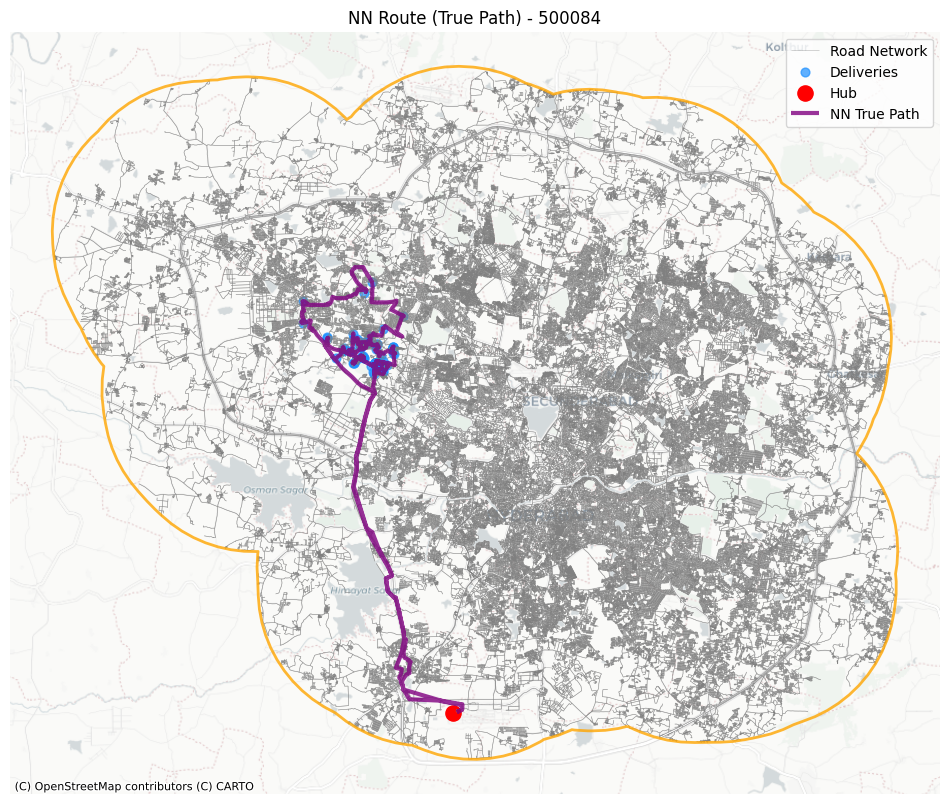

In [71]:
gdfs = {
    'deliveries': cluster_df,
    'hub': hub,
    'admin': hyd_buffered_gdf_3857,
    'edges': edges_exp_3857
}

plot_route_on_map(
    G_osmnx_expanded,
    result_nn['ordered_node_ids'], gdfs,
    cluster_label=result_nn['assigned_pincode'],
    savefig=True
    )

In [54]:
result_nn

{'assigned_pincode': '500084',
 'algorithm': 'Nearest Neighbor',
 'ordered_node_ids': [2578563669,
  np.int64(351875612),
  np.int64(1699091370),
  np.int64(1042219307),
  np.int64(12718183721),
  np.int64(3602308413),
  np.int64(11135474027),
  np.int64(12800012561),
  np.int64(11032104731),
  np.int64(10301765791),
  np.int64(2807852291),
  np.int64(2807852299),
  np.int64(11033695528),
  np.int64(12086549825),
  np.int64(2249841991),
  np.int64(6507536169),
  np.int64(11306518107),
  np.int64(1301947596),
  np.int64(2852837352),
  np.int64(1699060701),
  np.int64(1699084291),
  np.int64(3602310696),
  np.int64(2232093789),
  np.int64(2231576522),
  np.int64(2228997848),
  np.int64(2231576435),
  np.int64(3602310144),
  np.int64(2231576861),
  np.int64(2228998065),
  np.int64(2231577306),
  np.int64(7694025351),
  np.int64(3602309654),
  np.int64(2231948989),
  np.int64(2231948978),
  np.int64(2231949097),
  np.int64(7694126509),
  np.int64(2232094113),
  np.int64(1301983319),
  np.i

In [46]:
deliveries.assigned_pincode.unique()

array(['500001', '500033', '500081', '500084', '500032'], dtype=object)

In [72]:
def optimize_routes_for_all_clusters(deliveries, hub, G, debug=False):
    results = []
    for cluster_label in deliveries['assigned_pincode'].unique():
        if cluster_label in ["500001"]:
            continue
        print(f"Processing Cluster for Pincode {cluster_label}")
        cluster_df = deliveries[deliveries['assigned_pincode'] == cluster_label]
        try:
            result = nearest_neighbor_route(
                cluster_df, hub, G,
                cluster_label=cluster_label, debug=debug
            )
            results.append(result)
        except Exception as e:
            print(f"Cluster {cluster_label}: Error - {e}")
            # Optionally append a failed result dict
    return results

# Usage
results = optimize_routes_for_all_clusters(deliveries, hub, G_osmnx_expanded, debug=True)
results_df = pd.DataFrame(results)


Processing Cluster for Pincode 500033
Hub node: 2578563669
Delivery nodes: [np.int64(1324174605), np.int64(1314804081), np.int64(1324174605), np.int64(1324174605), np.int64(3602300077), np.int64(1324174605), np.int64(3602299822), np.int64(3602299822), np.int64(12520870329), np.int64(3579914072), np.int64(1324174605), np.int64(10703286800), np.int64(356327976), np.int64(2881689852), np.int64(2881689852), np.int64(1324174605), np.int64(11843664150), np.int64(2461452194), np.int64(3670021848), np.int64(2822546668), np.int64(2822546668), np.int64(2822546668), np.int64(2822546668), np.int64(1948881751), np.int64(324210294), np.int64(3146877632), np.int64(3579915379), np.int64(3579915252), np.int64(11133276001), np.int64(1312749347), np.int64(11885729740), np.int64(7000601823), np.int64(3579914193), np.int64(7682662072), np.int64(3602300218), np.int64(4173972755), np.int64(11043722956), np.int64(4260151403), np.int64(2881689852), np.int64(12520870329), np.int64(12520870329), np.int64(2881689

In [76]:
results_df

assigned_pincode         algorithm  \
0           500033  Nearest Neighbor   
1           500081  Nearest Neighbor   
2           500084  Nearest Neighbor   
3           500032  Nearest Neighbor   

                                    ordered_node_ids  \
0  [2578563669, 11133276001, 1293103435, 41739727...   
1  [2578563669, 9684884111, 11491085248, 31715964...   
2  [2578563669, 351875612, 1699091370, 1042219307...   
3  [2578563669, 10081763564, 5432656045, 22460728...   

                                      ordered_latlon  total_distance_km  \
0  [(17.2359885, 78.4185089), (17.40569, 78.40373...         131.192344   
1  [(17.2359885, 78.4185089), (17.4288942, 78.374...         123.266986   
2  [(17.2359885, 78.4185089), (17.4509127, 78.363...         126.710136   
3  [(17.2359885, 78.4185089), (17.4233063, 78.347...          88.643928   

   run_time_seconds notes  
0         96.995744        
1         60.241970        
2         65.637260        
3         22.902496

### Plots

In [ ]:
gdfs = {
    'deliveries': cluster_df,
    'hub': hub,
    'admin': hyd_buffered_gdf_3857,
    'edges': edges_exp_3857
}

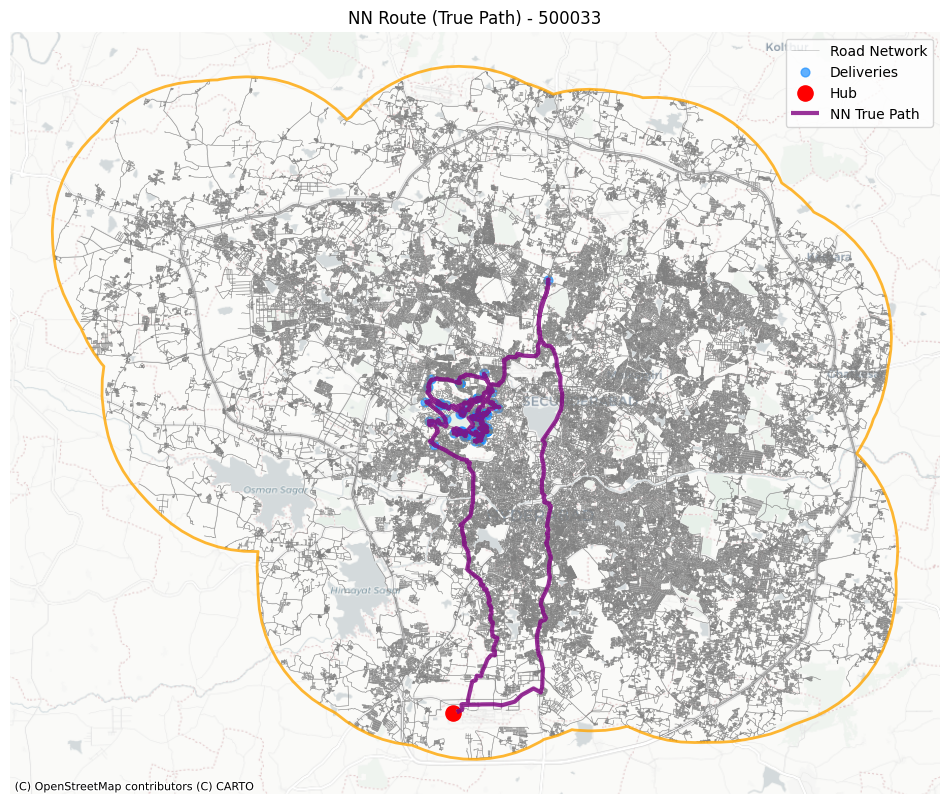

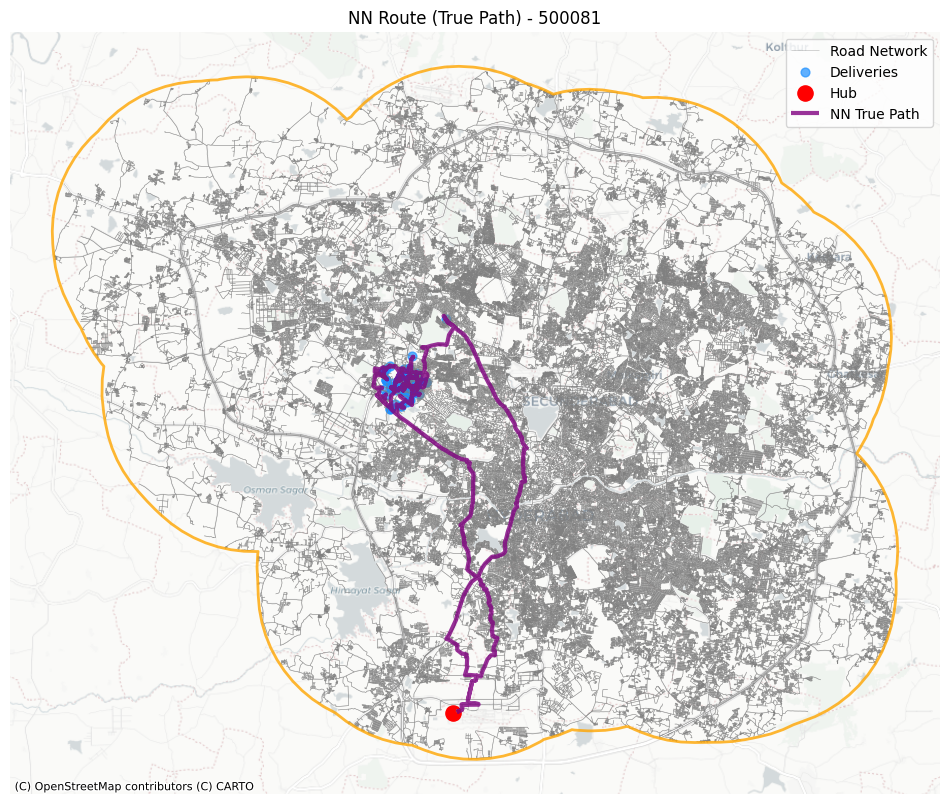

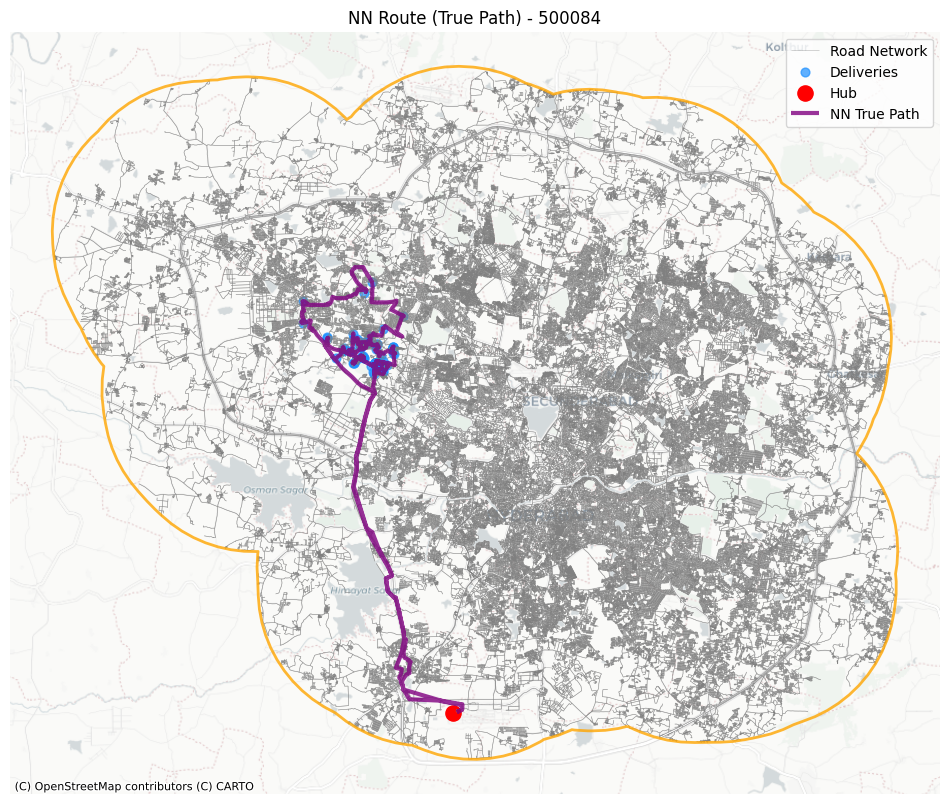

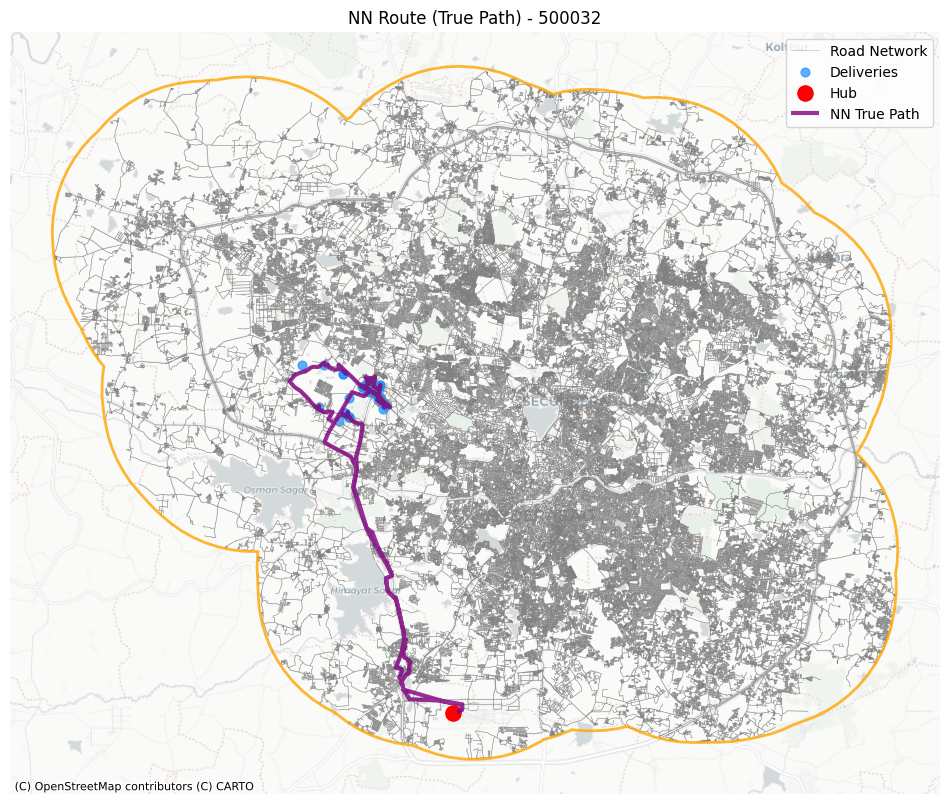

In [80]:
for result in results:
    node_ids = result['ordered_node_ids']
    cluster_label = result['assigned_pincode']
    cluster_df = deliveries[deliveries['assigned_pincode'] == cluster_label]
    gdfs['deliveries'] = cluster_df
    plot_route_on_map(
        G_osmnx_expanded,
        node_ids, gdfs,
        cluster_label=cluster_label,
        savefig=True
    )
